In [1]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

sys.path.append('/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code')
import nibabel as nib
from dn_utils.behavioral_models import load_behavioral_data         
from nilearn import plotting
from nistats.second_level_model import SecondLevelModel

### Load statistical maps 

In this section statistical maps (output .nii files from first-level GLM analysis) are loaded. Additional metadata for subject labels stored in `meta` dictionary is also loaded. Next, individual t-maps for left minus right button press contrast are plotted on glass brain models (fixed statistical threshold). Note subject m19 responding with reversed grips (technical error).

In [2]:
# Load metadata
beh_dir = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/" \
          "data/main_fmri_study/sourcedata/behavioral"
_, meta = load_behavioral_data(root=beh_dir, verbose=False)
n_subjects, n_conditions = len(meta['dim1']), len(meta['dim2'])

# Load t-map images (first level output)
out_dir = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/data/"\
          "main_fmri_study/derivatives/nistats/buttonpress"

tmap_files = [sorted([os.path.join(out_dir, file) 
              for file in os.listdir(out_dir) if task in file]) 
              for task in ['prlrew', 'prlpun']]

tmap_img = [[None] * n_subjects] * n_conditions
for sub_idx in range(n_subjects):
    for con_idx in range(n_conditions):
        tmap_img[con_idx][sub_idx] = nib.load(tmap_files[con_idx][sub_idx])

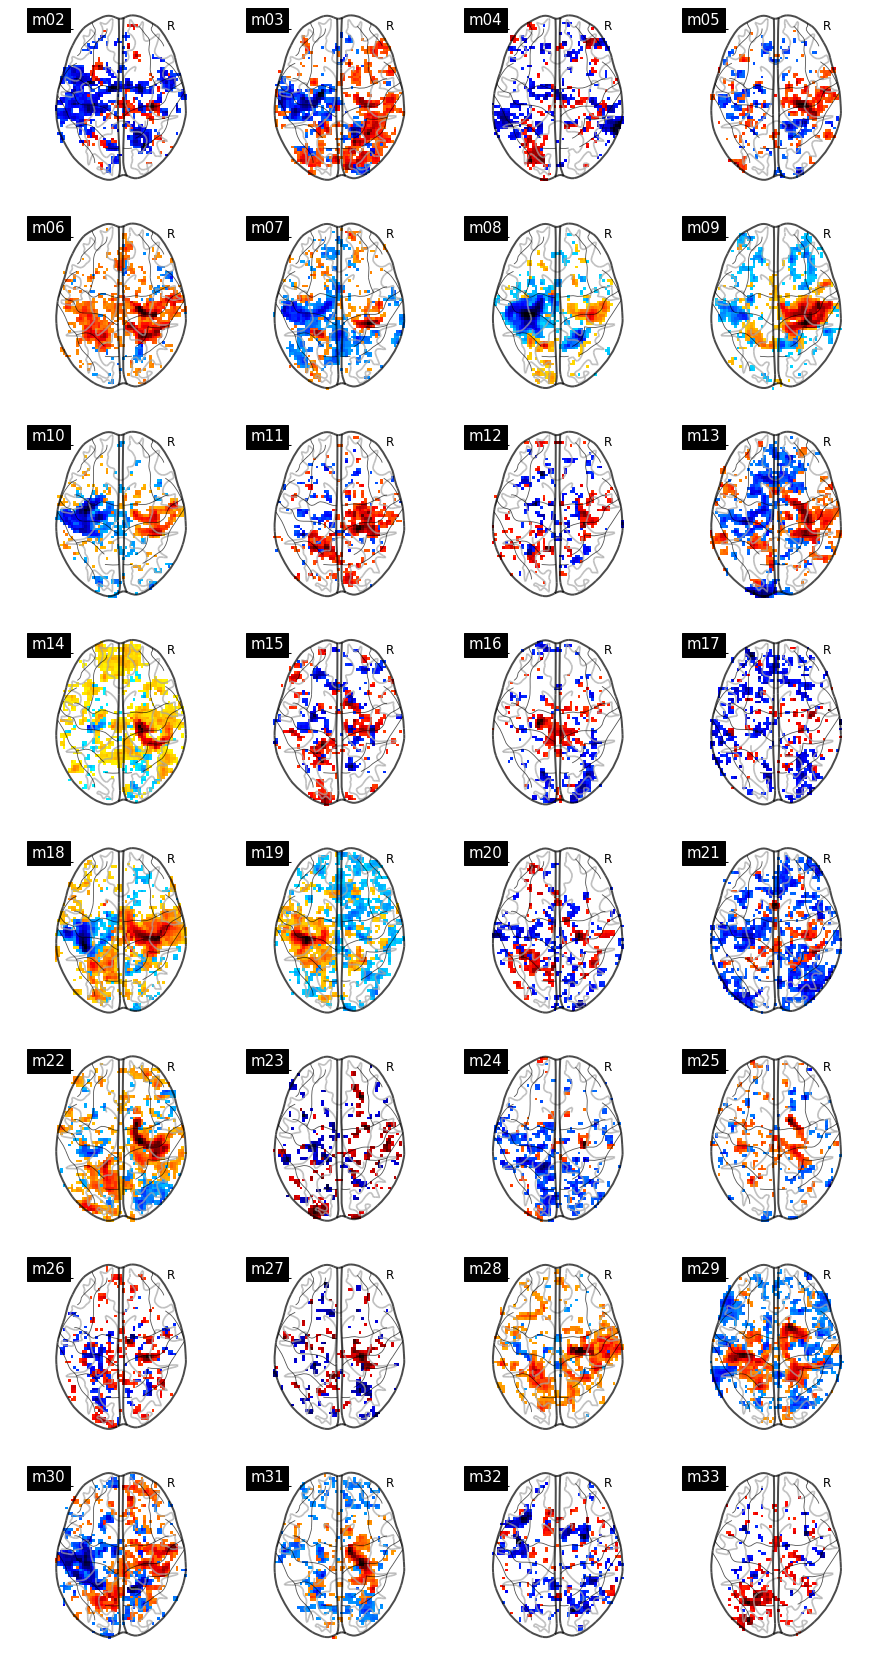

In [7]:
fig, ax = plt.subplots(
    nrows=8, ncols=4, 
    facecolor='w', figsize=(15, 30))

for cidx, tmap in enumerate(tmap_img[0]):
    plotting.plot_glass_brain(
        tmap, 
        colorbar=False, 
        threshold=2.5,
        title=meta['dim1'][cidx],
        axes=ax[int(cidx / 4)][int(cidx % 4)],
        plot_abs=False,
        display_mode='z')

### Group analysis

Here, group analysis is performed for left minus right button press contrast. All subject data from both task conditions is considered. Group level statistical map for main effect is then calculated. Then the result is displayed on the MNI152 non-linear asymmetric template (version 2009c; default template for fmriprep). Resulting maps are thresholded with uncorrected p-value < 0.001.

In [8]:
second_level_input = [tmap for tmaps in tmap_img for tmap in tmaps]

design_matrix = pd.DataFrame([1] * len(second_level_input),
                             columns=['intercept'])

second_level_model = SecondLevelModel(smoothing_fwhm=8)
second_level_model = second_level_model.fit(
    second_level_input, 
    design_matrix=design_matrix)

z_map = second_level_model.compute_contrast(output_type='z_score')

/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


/home/kmb/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


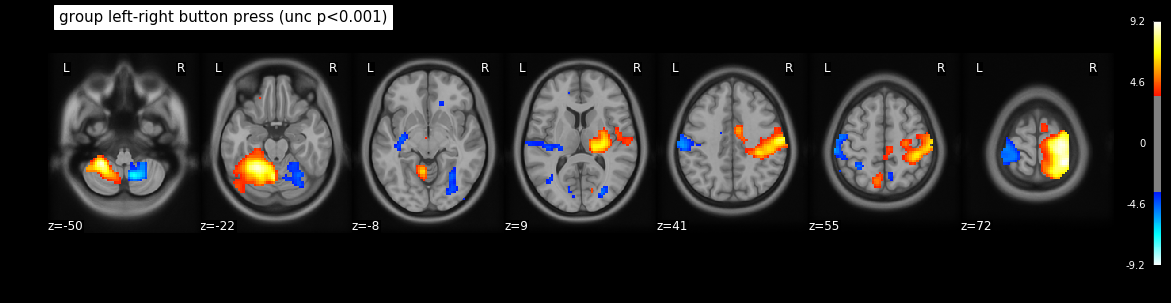

In [12]:
mni152nlin2009c = "mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/"\
                  "mni_icbm152_t1_tal_nlin_asym_09c.nii"
bg_img = nib.load(mni152nlin2009c)

p_val = 0.0001
fig, ax = plt.subplots(ncols=1, nrows=1, facecolor='k', figsize=(20, 5))
display = plotting.plot_stat_map(
    z_map,
    bg_img=bg_img,
    axes=ax,
    threshold=norm.isf(p_val),
    colorbar=True,
    display_mode='z',
    title='group left-right button press (unc p<0.001)')

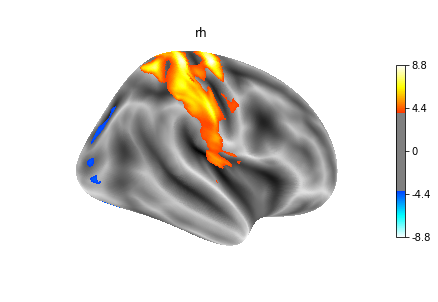

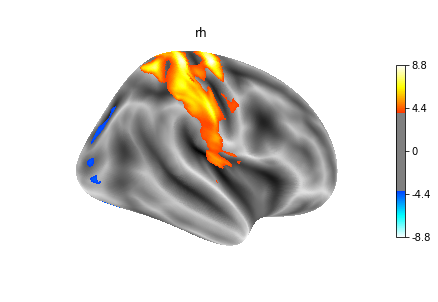

In [14]:
# (optional) Mapping results to the cortical surface
from nilearn import surface

freesurfer_dir = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/"\
                 "data/main_fmri_study/derivatives/freesurfer/" 
pial_right = freesurfer_dir + "fsaverage/surf/rh.pial"
infl_right = freesurfer_dir + "fsaverage/surf/rh.inflated"
sulc_right = freesurfer_dir + "/fsaverage/surf/rh.sulc"

texture = surface.vol_to_surf(z_map, pial_right)

plotting.plot_surf_stat_map(
    infl_right,
    texture,
    hemi='right', 
    title='rh', 
    colorbar=True, 
    threshold=4,
    bg_map=sulc_right)